<a href="https://colab.research.google.com/github/parulnith/Demo1/blob/master/Testing_and_Remediating_Bias_constrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 10: Testing and Remediating Bias in an XGBoost Credit Model

## Setting the environment

Download the [zipped **data_and_package** folder](https://github.com/ml-for-high-risk-apps-book/Machine-Learning-for-High-Risk-Applications-Book/blob/main/code/data_and_package.zip) onto your local system and save it as `Data.zip`. 

In [1]:
# Upload the downloaded zipped file from your system to the colab environment. 
from google.colab import files
uploaded = files.upload()

Saving Data.zip to Data.zip


In [2]:
!unzip -q "/content/Data.zip" 
%cd /content/Data

/content/Data


In [3]:
# Installing the libraries
%pip install h2o 
%pip install shap
%pip install 'XGBoost==1.6'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 177.4 MB 42 kB/s 
  Created wheel for h2o: filename=h2o-3.38.0.2-py2.py3-none-any.whl size=177521195 sha256=8380aa2f2bb2ea3525ce0fced089f00e259245efc47271ec4753111d469c2a75
  Stored in directory: /root/.cache/pip/wheels/e4/ef/ab/a9b2e452e18b3dfea0b6114bc57c3b9e8b0e464eb2d03230e1
Successfully built h2o
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 7.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 193.7 MB 34 kB/s 
  Attempting uninstall: XGBoost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


## <a name="model-testing"></a>1. Evaluating an XGBoost Model




### Train the Model

- Since the Disparate Impact Analysis(DIA) analysis will focus on model outcomes (rather than scores), choose a cutoff in probability space.


In [4]:
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import sklearn

import shap
np.random.seed(42)

In [5]:
data = pd.read_csv('../Data/Data/credit_line_increase.csv')

data['SEX'] = np.where(data['SEX'] == 1, 'male', 'female')
race_map = {1: 'hispanic', 2: 'black', 3: 'white', 4: 'asian'}
data['RACE'] = data['RACE'].apply(lambda x: race_map[x])

In [6]:
# Modify the data so there is a distributional difference between borrowers of different race/ethnicities.

new_limit_bal = data['LIMIT_BAL'] - 20000*np.random.randn(len(data))
new_limit_bal[new_limit_bal <= 10000] = 10000
data['LIMIT_BAL'] = np.where((data['RACE'] == 'hispanic') | (data['RACE'] == 'black'), 
                             new_limit_bal, 
                             data['LIMIT_BAL'])

for i in range(1, 7):
    delta = 1000*np.random.randn(len(data))
    new_pay = data[f'PAY_AMT{i}'] - delta
    new_pay[new_pay < 0] = 0

    new_bill = data[f'BILL_AMT{i}'] - delta
    new_bill[new_bill < 0] = 0

    data[f'PAY_AMT{i}'] = np.where((data['RACE'] == 'hispanic') | (data['RACE'] == 'black'), 
                                   new_pay, 
                                   data[f'PAY_AMT{i}'])
    data[f'BILL_AMT{i}'] = np.where((data['RACE'] == 'hispanic') | (data['RACE'] == 'black'), 
                                    new_bill, 
                                    data[f'BILL_AMT{i}']) 

In [7]:
seed = 12345
np.random.seed(seed)

split_train_test = 2/3

split = np.random.rand(len(data)) < split_train_test
train = data[split].copy()
test = data[~split].copy()

split_test_valid = 1/2

split = np.random.rand(len(test)) < split_test_valid
valid = test[split].copy()
test = test[~split].copy()

del data

print(f"Train/Validation/Test sizes: {len(train)}/{len(valid)}/{len(test)}")

Train/Validation/Test sizes: 19919/5045/5036


In [8]:
id_col = 'ID'
groups = ['SEX', 'RACE', 'EDUCATION', 'MARRIAGE', 'AGE']
target = 'DELINQ_NEXT'
features = [col for col in train.columns if col not in groups + [id_col, target]]

dtrain = xgb.DMatrix(train[features], 
                     label=train[target])

dvalid = xgb.DMatrix(valid[features], 
                     label=valid[target])

In [9]:
corr = pd.DataFrame(train[features + [target]].corr(method='spearman')[target]).iloc[:-1]

def get_monotone_constraints(data, target, corr_threshold):
    """Calculate monotonic constraints.
    
    Using a cutoff on Spearman correlation between features and target, return a tuple ready to pass into XGBoost. 

    
    Args:
        data (pd.DataFrame): A DataFrame containing the features in the order they appear to XGBoost, as well as the target variable.
        target (str): The name of the column with the target variable in 'data'.
        corr_threshold (float): The Spearman correlation threshold.

    Returns:
        tuple: A tuple with values in {-1, 0, 1}, where each element corresponds to a column in data (excluding the target itself). Ready to pass into xgb.train()

    """
    
    corr = pd.Series(data.corr(method='spearman')[target]).drop(target)
    monotone_constraints = tuple(np.where(corr < -corr_threshold, 
                                          -1, 
                                          np.where(corr > corr_threshold,
                                                   1, 
                                                   0)))
    return monotone_constraints

correlation_cutoff = 0.1

monotone_constraints = get_monotone_constraints(train[features+[target]],
                                                target,
                                                correlation_cutoff)

In [10]:
# Feed the model the global bias
base_score = train[target].mean()

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'eta': 0.05,
    'subsample': 0.75,
    'colsample_bytree': 0.8,
    'max_depth': 5,
    'base_score': base_score,
    'monotone_constraints': dict(zip(features, monotone_constraints)),
    'seed': seed
}

# Train using early stopping on the validation dataset.
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

model_constrained = xgb.train(params,         
                              dtrain,                   
                              num_boost_round=200,                     
                              evals=watchlist,
                              early_stopping_rounds=10,
                              verbose_eval=False)

train[f'p_{target}'] = model_constrained.predict(dtrain)
valid[f'p_{target}'] = model_constrained.predict(dvalid)
test[f'p_{target}'] = model_constrained.predict(xgb.DMatrix(test[features], label=test[target]))

In [11]:
# Select the optimal probability cutoff by maximizing the F1 score on validation data. 

def perf_metrics(y_true, y_score, pos=1, neg=0, res=0.01):
    """ 
    Calculates precision, recall, and f1 given outcomes and probabilities.
    
    Args:
        y_true: Array of binary outcomes
        y_score: Array of assigned probabilities.
        pos: Primary target value, default 1.
        neg: Secondary target value, default 0.
        res: Resolution by which to loop through cutoffs, default 0.01.
    
    Returns:
        Pandas dataframe of precision, recall, and f1 values. 
    """
    
    eps = 1e-20 # for safe numerical operations
    
    # init p-r roc frame
    prauc_frame = pd.DataFrame(columns=['cutoff', 'recall', 'precision', 'f1'])
    
    # loop through cutoffs to create p-r roc frame
    for cutoff in np.arange(0, 1 + res, res):

        # binarize decision to create confusion matrix values
        decisions = np.where(y_score > cutoff , 1, 0)
        
        # calculate confusion matrix values
        tp = np.sum((decisions == pos) & (y_true == pos))
        fp = np.sum((decisions == pos) & (y_true == neg))
        tn = np.sum((decisions == neg) & (y_true == neg))
        fn = np.sum((decisions == neg) & (y_true == pos))
        
        # calculate precision, recall, and f1
        recall = (tp + eps)/((tp + fn) + eps)
        precision = (tp + eps)/((tp + fp) + eps)
        f1 = 2/((1/(recall + eps)) + (1/(precision + eps)))
        
        # add new values to frame
        prauc_frame = prauc_frame.append({'cutoff': cutoff,
                                          'recall': recall,
                                          'precision': precision,
                                          'f1': f1}, 
                                          ignore_index=True)
        
    return prauc_frame


model_metrics = perf_metrics(y_true=valid[target], y_score=model_constrained.predict(dvalid))


In [12]:
model_metrics.loc[model_metrics['f1'].idxmax()]

cutoff       0.230000
recall       0.592528
precision    0.525829
f1           0.557190
Name: 23, dtype: float64

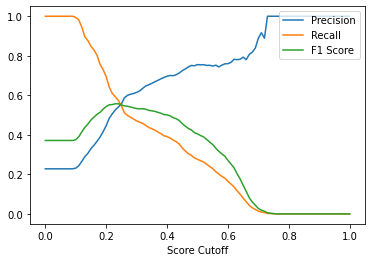

In [13]:
best_cut = model_metrics.loc[model_metrics['f1'].idxmax(), 'cutoff']
best_cut_original = best_cut

fig, ax = plt.subplots()
ax.plot(model_metrics['cutoff'], model_metrics['precision'], label='Precision')
ax.plot(model_metrics['cutoff'], model_metrics['recall'], label='Recall')
ax.plot(model_metrics['cutoff'], model_metrics['f1'], label='F1 Score')
ax.legend(loc=1)
ax.set_xlabel('Score Cutoff')

fig.savefig('../Data/Data/Figures/model_metrics.svg')

In [14]:
def get_confusion_matrix(frame, y, yhat, by=None, level=None, cutoff=0.5):
    """ 
    Creates confusion matrix from pandas dataframe of y and yhat values, can be sliced by a variable and level.
    
    Args:
        frame: Pandas dataframe of actual (y) and predicted (yhat) values.
        y: Name of actual value column.
        yhat: Name of predicted value column.
        by: By variable to slice frame before creating confusion matrix, default None.
        level: Value of by variable to slice frame before creating confusion matrix, default None.
        cutoff: Cutoff threshold for confusion matrix, default 0.5. 

    Returns:
        Confusion matrix as pandas dataframe. 
    """
    
    # determine levels of target (y) variable
    # sort for consistency
    level_list = list(frame[y].unique())
    level_list.sort(reverse=True)

    # init confusion matrix
    cm_frame = pd.DataFrame(columns=['actual: ' +  str(i) for i in level_list], 
                            index=['predicted: ' + str(i) for i in level_list])
    
    # don't destroy original data
    frame_ = frame.copy(deep=True)
    
    # convert numeric predictions to binary decisions using cutoff
    dname = 'd_' + str(y)
    frame_[dname] = np.where(frame_[yhat] > cutoff , 1, 0)
    
    # slice frame
    if (by is not None) & (level is not None):
        frame_ = frame_[frame[by] == level]
    
    # calculate size of each confusion matrix value
    for i, lev_i in enumerate(level_list):
        for j, lev_j in enumerate(level_list):
            cm_frame.iat[j, i] = frame_[(frame_[y] == lev_i) & (frame_[dname] == lev_j)].shape[0]
    
    return cm_frame

get_confusion_matrix(test, target, f'p_{target}', cutoff=best_cut)

,actual: 1,actual: 0
predicted: 1,640,631
predicted: 0,457,3308


### Confusion Matrix Disparity Metrics

In [15]:
metric_dict = {
'Prevalence': '(tp + fn) / (tp + tn +fp + fn)', # how much default actually happens for this group
'Accuracy': '(tp + tn) / (tp + tn + fp + fn)', # how often the model predicts default and non-default correctly for this group
'True Positive Rate': 'tp / (tp + fn)',  # out of the people in the group *that did* default, how many the model predicted *correctly* would default              
'Precision': 'tp / (tp + fp)',  # out of the people in the group the model *predicted* would default, how many the model predicted *correctly* would default
'Specificity': 'tn / (tn + fp)', # out of the people in the group *that did not* default, how many the model predicted *correctly* would not default
'Negative Predicted Value': 'tn / (tn + fn)', # out of the people in the group the model *predicted* would not default, how many the model predicted *correctly* would not default  

'False Positive Rate': 'fp / (tn + fp)', # out of the people in the group *that did not* default, how many the model predicted *incorrectly* would default
'False Discovery Rate': 'fp / (tp + fp)', # out of the people in the group the model *predicted* would default, how many the model predicted *incorrectly* would default

'False Negative Rate': 'fn / (tp + fn)', # out of the people in the group *that did* default, how many the model predicted *incorrectly* would not default
'False Omissions Rate': 'fn / (tn + fn)'  # out of the people in the group the model *predicted* would not default, how many the model predicted *incorrectly* would not default
}


def confusion_matrix_parser(expression):
    
    # tp | fp       cm_dict[level].iat[0, 0] | cm_dict[level].iat[0, 1]
    # -------  ==>  --------------------------------------------
    # fn | tn       cm_dict[level].iat[1, 0] | cm_dict[level].iat[1, 1]

    expression = expression.replace('tp', 'cm_dict[level].iat[0, 0]')\
                           .replace('fp', 'cm_dict[level].iat[0, 1]')\
                           .replace('fn', 'cm_dict[level].iat[1, 0]')\
                           .replace('tn', 'cm_dict[level].iat[1, 1]')

    return expression

In [16]:
# initialize dict of confusion matrices and corresponding rows of dataframe
sex_confusion_mats = {'male': get_confusion_matrix(test, target, 
                                                   f'p_{target}', by='SEX', 
                                                   level='male', cutoff=best_cut), 
                      'female': get_confusion_matrix(test, target, 
                                                     f'p_{target}', by='SEX', 
                                                     level='female', cutoff=best_cut)} 

def confusion_matrix_metrics(cm_dict, metric_dict):
    levels = list(cm_dict.keys())

    metrics_frame = pd.DataFrame(index=levels) # frame for metrics

    for level in levels:
        for metric in metric_dict.keys():

            # parse metric expressions into executable pandas statements
            expression = confusion_matrix_parser(metric_dict[metric])

            # dynamically evaluate metrics to avoid code duplication
            metrics_frame.loc[level, metric] = eval(expression)  

    return metrics_frame

sex_confusion_metrics = confusion_matrix_metrics(sex_confusion_mats, metric_dict)

In [17]:
sex_confusion_metrics

,Prevalence,Accuracy,True Positive Rate,Precision,Specificity,Negative Predicted Value,False Positive Rate,False Discovery Rate,False Negative Rate,False Omissions Rate
male,0.238264,0.776880,0.586864,0.528626,0.836315,0.866163,0.163685,0.471374,0.413136,0.133837
female,0.204583,0.788543,0.580800,0.485944,0.841975,0.886482,0.158025,0.514056,0.419200,0.113518


In [18]:
race_levels = list(race_map.values())
race_confusion_mats = {level: get_confusion_matrix(test, target, f'p_{target}', by='RACE', 
                                                   level=level, cutoff=best_cut) for level in race_levels} 
race_confusion_metrics = confusion_matrix_metrics(race_confusion_mats, metric_dict)

In [19]:
race_confusion_metrics

,Prevalence,Accuracy,True Positive Rate,Precision,Specificity,Negative Predicted Value,False Positive Rate,False Discovery Rate,False Negative Rate,False Omissions Rate
hispanic,0.399393,0.734075,0.582278,0.701220,0.835017,0.750378,0.164983,0.298780,0.417722,0.249622
black,0.386707,0.711984,0.570312,0.644118,0.801314,0.747320,0.198686,0.355882,0.429688,0.252680
white,0.107075,0.812620,0.577381,0.303125,0.840828,0.943155,0.159172,0.696875,0.422619,0.056845
asian,0.101010,0.835017,0.626667,0.332155,0.858427,0.953411,0.141573,0.667845,0.373333,0.046589


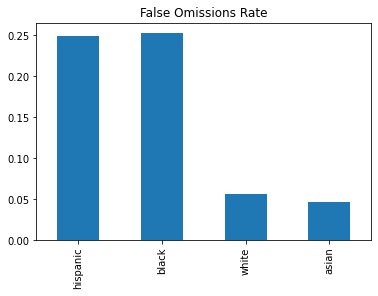

In [20]:
_ = race_confusion_metrics['False Omissions Rate'].plot(kind='bar', title='False Omissions Rate')

In [21]:
race_disparity_frame = race_confusion_metrics/race_confusion_metrics.loc['white', :]
race_disparity_frame.columns=[col + ' Disparity' for col in race_confusion_metrics.columns]

# small utility function to format pandas table output
def disparate_red(val, parity_threshold_low=0.8, parity_threshold_hi=1.25):
    color = 'white' if (parity_threshold_low < val < parity_threshold_hi) else 'red'
    return 'color: %s' % color 

race_disparity_frame.style.applymap(disparate_red)

,Prevalence Disparity,Accuracy Disparity,True Positive Rate Disparity,Precision Disparity,Specificity Disparity,Negative Predicted Value Disparity,False Positive Rate Disparity,False Discovery Rate Disparity,False Negative Rate Disparity,False Omissions Rate Disparity
hispanic,3.730048,0.903344,1.008482,2.313301,0.993089,0.795605,1.036509,0.428743,0.988411,4.391234
black,3.611567,0.876159,0.987758,2.124924,0.953005,0.792362,1.248249,0.510683,1.016725,4.445032
white,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
asian,0.943362,1.027562,1.085361,1.095771,1.020931,1.010875,0.889434,0.958342,0.883380,0.819573


In [22]:
sex_disparity_frame = sex_confusion_metrics/sex_confusion_metrics.loc['male', :]
sex_disparity_frame.columns=[col + ' Disparity' for col in sex_confusion_metrics.columns]

# small utility function to format pandas table output
def disparate_red(val, parity_threshold_low=0.8, parity_threshold_hi=1.25):
    color = 'white' if (parity_threshold_low < val < parity_threshold_hi) else 'red'
    return 'color: %s' % color 

sex_disparity_frame.style.applymap(disparate_red)

,Prevalence Disparity,Accuracy Disparity,True Positive Rate Disparity,Precision Disparity,Specificity Disparity,Negative Predicted Value Disparity,False Positive Rate Disparity,False Discovery Rate Disparity,False Negative Rate Disparity,False Omissions Rate Disparity
male,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
female,0.858640,1.015013,0.989666,0.919258,1.006768,1.023458,0.965422,1.090548,1.014679,0.848185


### Fair Lending Disparity Analysis

In [23]:
from scipy.stats import ttest_ind, chisquare, fisher_exact, chi2_contingency


def air_statistical_signif(group_count, group_favorable, reference_count, reference_favorable):
    # Perform a chi-square test 
    # (or Fisher's exact when cells in the contingency test have less than 30 individuals in them).
    
    group_unfavorable = group_count - group_favorable
    reference_unfavorable = reference_count - reference_favorable
    
    contingency_table = np.array([[group_favorable, group_unfavorable], 
                                  [reference_favorable, reference_unfavorable]])
    
    if np.min(contingency_table) < 30:
        _, p = fisher_exact(contingency_table)
    else:
        _, p, _, _ = chi2_contingency(contingency_table)
    
    return p

def smd_statistical_signif(group_scores, reference_scores):
    # Perform a one-sided t-test. An outcome of 1 is assumed to be favorable. 
    
    # We do not assume that the two scores have equal variance. Furthermore, we are testing 
    # against the alternative hypothesis that the group receives lower scores than the reference
    # group.
    _, p = ttest_ind(group_scores, reference_scores, equal_var=False, alternative='less')
    return p


def fair_lending_disparity(frame, y, yhat, demo_name, groups, reference_group, cutoff=0.5, favorable_outcome=0):
    """ 
    Creates a table of fair lending disparity metrics (AIR and SMD).
    
    Args:
        frame: Pandas dataframe of actual (y) and predicted (yhat) values with group membership.
        y: Name of actual value column.
        yhat: Name of predicted value column.
        demo_name: The name of the column containing the group information
        groups: The names of the groups in the demo_name column.
        reference_group: The control group.
        cutoff: Cutoff threshold for confusion matrix, default 0.5. 
        favorable_outcome: The value {0, 1} that corresponds to a desirable outcome.

    Returns:
        A DataFrame summarizing the fair lending metrics analysis
    """
    
    protected_groups = [group for group in groups if group != reference_group]
    groups_ordered = protected_groups + [reference_group]   
    
    temp_frame = frame.copy()
    temp_frame['model_outcome'] = np.where(temp_frame[yhat] <= cutoff, 0, 1)
    temp_frame['fav_outcome'] = temp_frame['model_outcome'] == favorable_outcome
    temp_frame['fav_score'] = temp_frame[yhat] if favorable_outcome else 1-temp_frame[yhat]
    
    disparity_table = pd.DataFrame(index=groups_ordered)
    
    disparity_table['Count'] = [len(temp_frame.loc[temp_frame[demo_name] == group]) for group in groups_ordered]
    disparity_table['Favorable Outcomes'] = [temp_frame.loc[temp_frame[demo_name] == group]['fav_outcome'].sum() 
                                             for group in groups_ordered]
    disparity_table['Favorable Rate'] = [disparity_table['Favorable Outcomes'][group]/disparity_table['Count'][group] 
                                         for group in groups_ordered]
    disparity_table['Mean Score'] = [temp_frame.loc[temp_frame[demo_name] == group][yhat].mean() 
                                             for group in groups_ordered]
    disparity_table['Std Score'] = [temp_frame.loc[temp_frame[demo_name].isin([reference_group, group])][yhat].std() 
                                             for group in groups_ordered]
    try:
        disparity_table['AIR'] = [disparity_table['Favorable Rate'][group]/disparity_table['Favorable Rate'][reference_group] 
                                  for group in groups_ordered]
    except:
        disparity_table['AIR'] = np.nan
        
    disparity_table['AIR p-value'] = [air_statistical_signif(disparity_table['Count'][group], 
                                                             disparity_table['Favorable Outcomes'][group],
                                                             disparity_table['Count'][reference_group],
                                                             disparity_table['Favorable Outcomes'][reference_group])
                                      for group in groups_ordered]

    disparity_table['SMD'] = [(disparity_table['Mean Score'][group] - 
                               disparity_table['Mean Score'][reference_group]) / 
                              disparity_table['Std Score'][group]
                              for group in groups_ordered]
    
    disparity_table['SMD p-value'] = [smd_statistical_signif(temp_frame.loc[temp_frame[demo_name] == group]['fav_score'],
                                                             temp_frame.loc[temp_frame[demo_name] == reference_group]['fav_score'])
                                      for group in groups_ordered]

    return disparity_table
    

In [24]:
fair_lending_disparity(train, y=target, yhat=f'p_{target}', 
                       demo_name='RACE', groups=race_levels, reference_group='white', 
                       cutoff=best_cut)

,Count,Favorable Outcomes,Favorable Rate,Mean Score,Std Score,AIR,AIR p-value,SMD,SMD p-value
hispanic,3828,2532,0.661442,0.251472,0.140340,0.816785,2.486524e-62,0.402701,1.112416e-75
black,3795,2530,0.666667,0.249250,0.140298,0.823236,3.419156e-58,0.386983,2.404163e-69
asian,6181,5041,0.815564,0.192749,0.118666,1.007103,4.270401e-01,-0.018608,8.488682e-01
white,6115,4952,0.809812,0.194957,0.119707,1.000000,1.000000e+00,0.000000,5.000000e-01


In [25]:
fair_lending_disparity(valid, y=target, yhat=f'p_{target}', 
                       demo_name='RACE', groups=race_levels, reference_group='white', 
                       cutoff=best_cut)

,Count,Favorable Outcomes,Favorable Rate,Mean Score,Std Score,AIR,AIR p-value,SMD,SMD p-value
hispanic,1016,673,0.662402,0.252734,0.145430,0.837224,4.258129e-13,0.353849,2.681033e-17
black,1008,676,0.670635,0.244080,0.143068,0.847631,1.089721e-11,0.299206,7.048277e-13
asian,1455,1160,0.797251,0.201322,0.127931,1.007663,7.137857e-01,0.000376,4.958869e-01
white,1566,1239,0.791188,0.201274,0.127872,1.000000,1.000000e+00,0.000000,5.000000e-01


In [26]:
fair_lending_disparity(test, y=target, yhat=f'p_{target}', 
                       demo_name='RACE', groups=race_levels, reference_group='white', 
                       cutoff=best_cut)

,Count,Favorable Outcomes,Favorable Rate,Mean Score,Std Score,AIR,AIR p-value,SMD,SMD p-value
hispanic,989,661,0.668352,0.254482,0.145333,0.839587,6.724095e-13,0.385930,1.358680e-19
black,993,653,0.657603,0.245002,0.140906,0.826084,8.459752e-15,0.330771,3.546580e-15
asian,1485,1202,0.809428,0.195896,0.123339,1.016807,3.773078e-01,-0.020253,7.122022e-01
white,1569,1249,0.796048,0.198394,0.125520,1.000000,1.000000e+00,0.000000,5.000000e-01


### Individual Fairness Analysis

In [27]:
def plot_group_residuals(frame, y, yhat, demo_name, groups, cutoff=0.5, favorable_outcome=0):
    """ 
    Generates a plot of logloss residuals for individuals who falsely received an unfavorable outcome.
    
    Args:
        frame: Pandas dataframe of actual (y) and predicted (yhat) values with group membership.
        y: Name of actual value column.
        yhat: Name of predicted value column.
        demo_name: The name of the column containing the group information
        groups: The names of the groups in the demo_name column.
        cutoff: Cutoff threshold for confusion matrix, default 0.5. 
        favorable_outcome: The value {0, 1} that corresponds to a desirable outcome.

    Returns:
        Axes of the plot
    """
    
    fig, axs = plt.subplots(1, len(groups), figsize=(5*len(groups), 5))
    for i, group in enumerate(groups):
        group_frame = frame.loc[frame[demo_name] == group].copy()
        group_frame[f'{yhat}_outcome'] = np.where(group_frame[yhat] > cutoff, 1, 0)
        
        group_frame[f'{y}_residual'] = -group_frame[y]*np.log(group_frame[yhat]) 
        group_frame[f'{y}_residual'] -= (1 - group_frame[y])*np.log(1 - group_frame[yhat]) 
        
        misclassified_obs = group_frame[(group_frame[y] == favorable_outcome) & 
                                        (group_frame[f'{yhat}_outcome'] == (1 - favorable_outcome))]
        axs[i].scatter(misclassified_obs[yhat], misclassified_obs[f'{y}_residual'], marker='o', alpha=0.3)
        axs[i].set_xlabel('Score')
        axs[i].set_ylabel('Residual')
        axs[i].set_title(group)

    fig.suptitle('Logloss Residuals')
    
    return axs

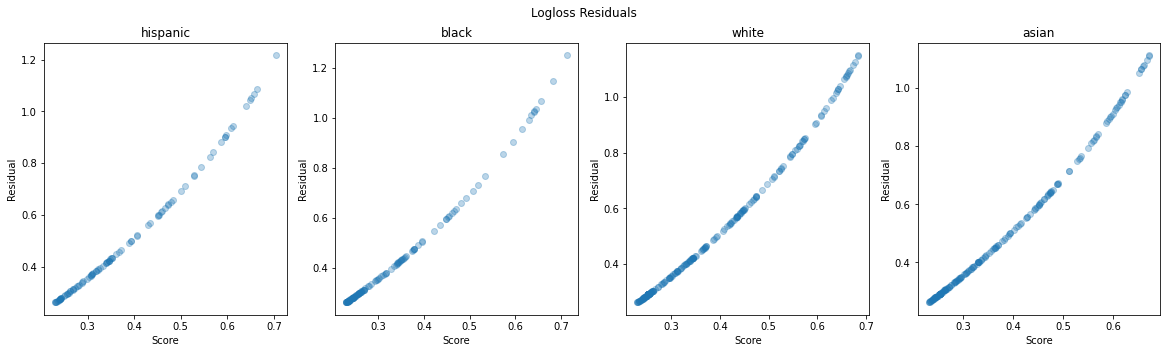

In [28]:
_ = plot_group_residuals(test, y=target, yhat=f'p_{target}', 
                       demo_name='RACE', groups=race_levels,
                       cutoff=best_cut)

In [29]:
# Examine outlying misclassified black observations

black_obs = test.loc[test['RACE'] == 'black'].copy()
black_obs[f'p_{target}_outcome'] = np.where(black_obs[f'p_{target}'] > best_cut, 1, 0)
        
misclassified_obs = black_obs[(black_obs[target] == 0) & 
                              (black_obs[f'p_{target}_outcome'] == 1)]

misclassified_obs.sort_values(by=f'p_{target}').head(3)[features]

,LIMIT_BAL,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
9941,10000.000000,0,0,2,0,0,0,30409.036893,32162.939612,28184.136253,28917.566577,29261.296517,7441.561131,3512.036893,1014.939612,2929.136253,0.000000,1306.296517,0.000000
12331,307138.301259,1,-1,-1,-1,-1,-2,405.705636,1315.070028,0.000000,1421.519763,683.323668,0.000000,2124.705636,0.000000,1019.275866,0.000000,683.323668,0.000000
13833,10000.000000,0,0,0,0,0,0,20201.849460,19633.776146,19665.654717,16005.621268,18961.473120,20520.298817,1404.849460,284.776146,156.654717,6044.621268,1854.473120,14245.298817


In [30]:
# We'll train an adversarial model that attempts to predict each observations' race/ethnicity (black/hispanic 
#  or asian/white). Compare an adversary that doesn't have access to the model's predictions with one
#  that does. If the model predictions meaningfully improve the performance of the adversary for certain
#  observations, there is a potential individual fairness concern.

train['protected'] = np.where((train['RACE'] == 'hispanic') | (train['RACE'] == 'black'), 1, 0)
valid['protected'] = np.where((valid['RACE'] == 'hispanic') | (valid['RACE'] == 'black'), 1, 0)

dtrain_adversary = xgb.DMatrix(train[features], 
                     label=train['protected'])

dvalid_adversary = xgb.DMatrix(valid[features], 
                     label=valid['protected'])

base_score_adversary = train['protected'].mean()

params_adversary = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'eta': 0.05,
    'subsample': 0.75,
    'colsample_bytree': 0.8,
    'max_depth': 5,
    'base_score': base_score_adversary,
    'seed': seed
}

# Train using early stopping on the validation dataset.
watchlist_adversary = [(dtrain_adversary, 'train'), (dvalid_adversary, 'eval')]

adversary_model = xgb.train(params,         
                              dtrain_adversary,                   
                              num_boost_round=200,                     
                              evals=watchlist_adversary,
                              early_stopping_rounds=10,
                              verbose_eval=False)

In [31]:
dtrain_adversary_ii = xgb.DMatrix(train[features + [f'p_{target}']], 
                     label=train['protected'])

dvalid_adversary_ii = xgb.DMatrix(valid[features + [f'p_{target}']], 
                     label=valid['protected'])

watchlist_adversary_ii = [(dtrain_adversary_ii, 'train'), (dvalid_adversary_ii, 'eval')]

adversary_model_ii = xgb.train(params,         
                              dtrain_adversary_ii,                   
                              num_boost_round=200,                     
                              evals=watchlist_adversary_ii,
                              early_stopping_rounds=10,
                              verbose_eval=False)

In [32]:
adversarial_outputs = pd.DataFrame({'protected': valid['protected'],
                                    'P(protected) (1)': adversary_model.predict(dvalid_adversary),
                                    'P(protected) (2)': adversary_model_ii.predict(dvalid_adversary_ii)})

In [33]:
adversarial_outputs['delta'] = adversarial_outputs['P(protected) (2)'] - adversarial_outputs['P(protected) (1)']
adversarial_outputs.loc[adversarial_outputs['protected'] == 1].sort_values('delta', ascending=False)

,protected,P(protected) (1),P(protected) (2),delta
24497,1,0.536095,0.769624,0.233530
27358,1,0.519031,0.739475,0.220444
14705,1,0.414197,0.633875,0.219678
29545,1,0.464907,0.675201,0.210294
2261,1,0.560291,0.736126,0.175836
...,...,...,...,...
12724,1,0.422407,0.251700,-0.170707
15626,1,0.501993,0.324216,-0.177777
13451,1,0.579766,0.401610,-0.178157
3995,1,0.577603,0.385716,-0.191887


In [34]:
most_affected_obs = adversarial_outputs.sort_values('delta', ascending=False).index[:5]

In [35]:
# TODO: Examine feature attributions for these observations.

valid.loc[24497]

ID                      24498
LIMIT_BAL        35844.470164
SEX                      male
RACE                    black
EDUCATION                   1
MARRIAGE                    2
AGE                        36
PAY_0                      -1
PAY_2                       2
PAY_3                       2
PAY_4                      -1
PAY_5                      -1
PAY_6                      -2
BILL_AMT1          393.000384
BILL_AMT2           161.61234
BILL_AMT3                 0.0
BILL_AMT4         1038.465074
BILL_AMT5          186.063655
BILL_AMT6                 0.0
PAY_AMT1                  0.0
PAY_AMT2                  0.0
PAY_AMT3          6016.681659
PAY_AMT4           678.465074
PAY_AMT5           216.063655
PAY_AMT6                  0.0
DELINQ_NEXT                 1
p_DELINQ_NEXT        0.327823
protected                   1
Name: 24497, dtype: object

In [36]:
explanation_data = valid[features + [f'p_{target}']]

adversarial_shap_values = shap.TreeExplainer(adversary_model_ii).shap_values(explanation_data)

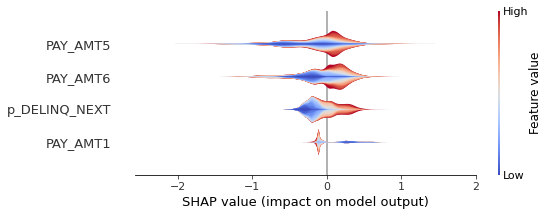

In [37]:
# Observe that higher model scores result in a positive contribution to the protected group prediction, however
# the relationship is nonlinear (the color gradient for p_DELINQ_NEXT does not smoothly move from cool to hot). 
# This suggests there are feature interactions with p_DELINQ_NEXT that are contributing towards the adversarial
# model prediction - these are interactions to investigate for proxy effects. 

shap.summary_plot(adversarial_shap_values, 
                  explanation_data, 
                  plot_type="layered_violin", 
                  color='coolwarm', max_display=4, show=False)

fig = plt.gcf()
fig.savefig('../Data/Data/Figures/shap_summary_violin.svg', bbox_inches='tight')

(-0.6025354146957398, 0.8483682900667191)

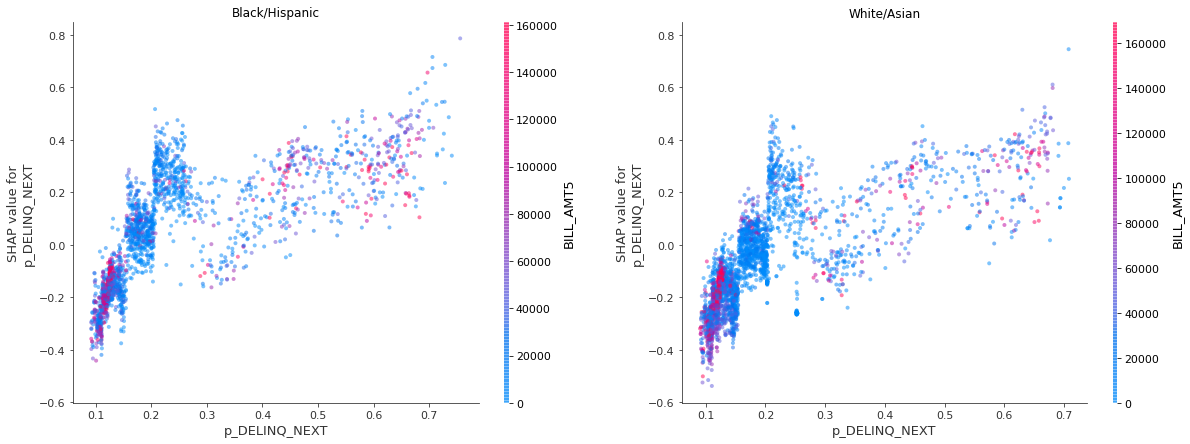

In [38]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 7))

shap.dependence_plot('p_DELINQ_NEXT', 
                     adversarial_shap_values[valid['protected'] == 1], 
                     explanation_data.loc[valid['protected'] == 1],
                     interaction_index='BILL_AMT5',
                     alpha=0.5,
                     ax=ax0,
                     show=False)

ax0.set_title('Black/Hispanic')

shap.dependence_plot('p_DELINQ_NEXT', 
                     adversarial_shap_values[valid['protected'] == 0], 
                     explanation_data.loc[valid['protected'] == 0],
                     interaction_index='BILL_AMT5',
                     alpha=0.5,
                     ax=ax1,
                     show=False)

ax1.set_title('White/Asian')

ylim = (np.min([ax0.get_ylim()[0], ax1.get_ylim()[0]]), 
        np.max([ax0.get_ylim()[1], ax1.get_ylim()[1]]))
               
ax0.set_ylim(ylim)
ax1.set_ylim(ylim)

In [39]:
# Calculate interaction values for the top 100 observations that had their predictions change the most
#  from adversary i to adversary ii.

explainer = shap.TreeExplainer(adversary_model_ii)
expected_value = explainer.expected_value[0]

In [40]:
explanation_data = valid[features + [f'p_{target}']] #  .loc[most_affected_obs]

shap_values = explainer.shap_values(explanation_data)
shap_interaction_values = explainer.shap_interaction_values(explanation_data)

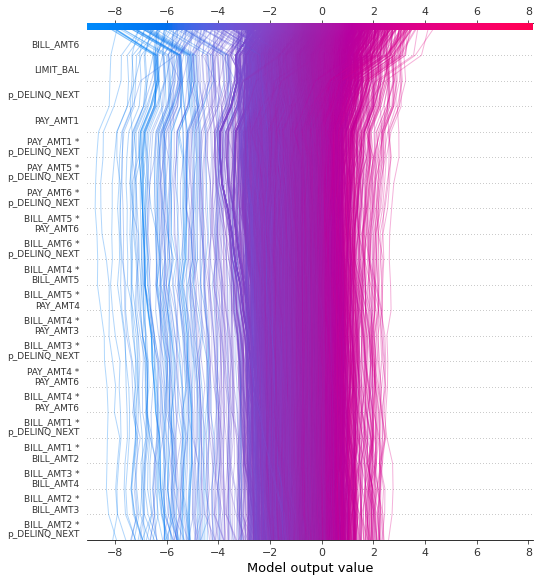

In [41]:
# shap.decision_plot(expected_value, shap_interaction_values, feature_names=features + [f'p_{target}'], link='logit',
#                   ignore_warnings=True, alpha=0.3)

shap.decision_plot(expected_value, shap_interaction_values, feature_names=features + [f'p_{target}'],
                  ignore_warnings=True, alpha=0.3, feature_order='hclust')

In [42]:
highlight_obs = np.where(valid.index.isin(most_affected_obs), 1, 0)

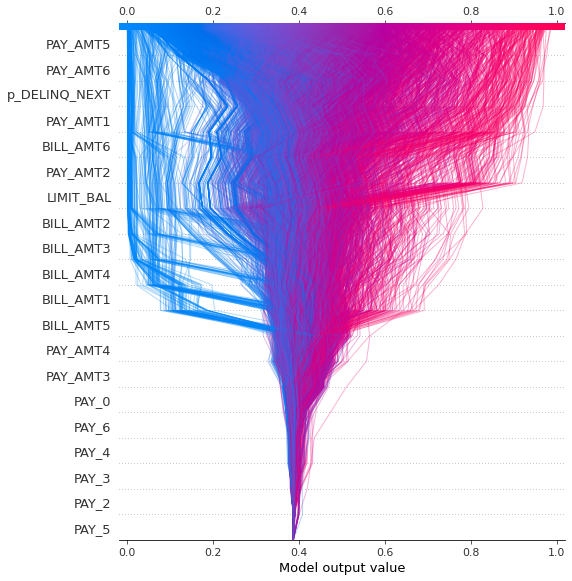

In [43]:
shap.decision_plot(expected_value, shap_values, feature_names=features + [f'p_{target}'], 
                   link='logit', ignore_warnings=True, alpha=0.3, highlight=highlight_obs)

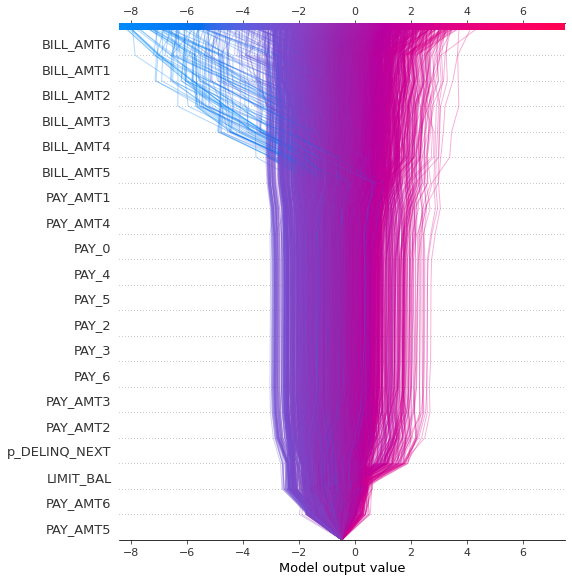

In [44]:
shap.decision_plot(expected_value, shap_values, 
                   feature_names=features + [f'p_{target}'], 
                   feature_order='hclust',
                   ignore_warnings=True, alpha=0.3)

## <a name="remediation"></a>2. Remediating Model Bias

### Pre-Processing

In [45]:
def reweight_dataset(frame, y, demo_name, groups):
    """
    Generates a weight for each observation according to the reweighting algorithm of 
    Kamiran and Kalders 2012, Data preprocessing techniques for classification without discrimination.
    
    Args:
        frame: Pandas dataframe of actual (y) and group information.
        y: Name of actual value column (assumed to be binary).
        demo_name: The name of the column containing the group information
        groups: The names of the groups in the demo_name column.

    Returns:
        A Series containing the new observation weights.
    """
    
    n = len(frame)
    
    freq_dict = {'pos': len(frame.loc[frame[y] == 1])/n,
                 'neg': len(frame.loc[frame[y] == 0])/n}
    
    freq_dict.update({group: frame[demo_name].value_counts()[group]/n for group in groups})
    
    weights = pd.Series(np.ones(n), index=frame.index)
    
    for label in [0, 1]:
        for group in groups:
            label_name = 'pos' if label == 1 else 'neg'
            freq = frame.loc[frame[y] == label][demo_name].value_counts()[group]/n
            weights[(frame[y] == label) & (frame[demo_name] == group)] *= freq_dict[group]*freq_dict[label_name]/freq
    
    return weights

In [46]:
train_weights = reweight_dataset(train, target, 'RACE', race_levels)

In [47]:
for race in race_levels:
    print(f"Mean outcome for {race}: {np.round(train.loc[train['RACE'] == race][target].mean(), 3)}")
    
    weighted_target = np.multiply(train.loc[train['RACE'] == race][target], 
                                  train_weights.loc[train['RACE'] == race])
    
    print(f"Mean outcome for {race} - reweighted: {np.round(weighted_target.mean(), 3)} \n")

Mean outcome for hispanic: 0.398
Mean outcome for hispanic - reweighted: 0.22 

Mean outcome for black: 0.4
Mean outcome for black - reweighted: 0.22 

Mean outcome for white: 0.112
Mean outcome for white - reweighted: 0.22 

Mean outcome for asian: 0.107
Mean outcome for asian - reweighted: 0.22 



In [48]:
dtrain = xgb.DMatrix(train[features], 
                     label=train[target],
                     weight=train_weights)


model_reweighted = xgb.train(params,         
                             dtrain,                   
                             num_boost_round=100,                     
                             evals=watchlist,
                             early_stopping_rounds=10,
                             verbose_eval=False)

In [49]:
reweighted_model_metrics = perf_metrics(y_true=valid[target], y_score=model_reweighted.predict(dvalid))
reweighted_best_cut = reweighted_model_metrics.loc[reweighted_model_metrics['f1'].idxmax(), 'cutoff']

In [50]:
test[f'p_{target}_reweighted'] = model_reweighted.predict(xgb.DMatrix(test[features], label=test[target]))

fair_lending_disparity(test, y=target, yhat=f'p_{target}_reweighted', 
                       demo_name='RACE', groups=race_levels, reference_group='white', 
                       cutoff=reweighted_best_cut)

,Count,Favorable Outcomes,Favorable Rate,Mean Score,Std Score,AIR,AIR p-value,SMD,SMD p-value
hispanic,989,676,0.683519,0.244535,0.123430,0.857953,1.405232e-10,0.316711,7.483325e-14
black,993,675,0.679758,0.237026,0.119661,0.853233,3.488056e-11,0.263935,2.291738e-10
asian,1485,1197,0.806061,0.202225,0.106000,1.011767,5.461674e-01,-0.030367,7.994670e-01
white,1569,1250,0.796686,0.205443,0.108412,1.000000,1.000000e+00,0.000000,5.000000e-01


In [51]:
train[f'p_{target}_reweighted'] = model_reweighted.predict(dtrain)

fair_lending_disparity(train, y=target, yhat=f'p_{target}_reweighted', 
                       demo_name='RACE', groups=race_levels, reference_group='white', 
                       cutoff=reweighted_best_cut)

,Count,Favorable Outcomes,Favorable Rate,Mean Score,Std Score,AIR,AIR p-value,SMD,SMD p-value
hispanic,3828,2631,0.687304,0.241057,0.118358,0.852508,1.707699e-41,0.327414,3.770271e-51
black,3795,2614,0.688801,0.239163,0.118124,0.854365,2.215019e-40,0.312029,2.802679e-46
asian,6181,5016,0.811519,0.200254,0.102573,1.006580,4.683808e-01,-0.019990,8.660998e-01
white,6115,4930,0.806214,0.202305,0.103216,1.000000,1.000000e+00,0.000000,5.000000e-01


In [52]:
def make_fair_objective(protected, lam):
    def fair_objective(pred, dtrain):
        """
        Fairness-aware cross-entropy loss objective function
        """
        label = dtrain.get_label()
        pred = 1.0 / (1.0 + np.exp(-pred))
        grad = (pred - label) - lam * (pred - protected)
        hess = (1 - lam) * pred * (1. - pred)
        
        return grad, hess
    return fair_objective

protected = np.where((train['RACE'] == 'hispanic') | (train['RACE'] == 'black'), 1, 0)
fair_objective = make_fair_objective(protected, lam=0.2)


In [53]:
dtrain = xgb.DMatrix(train[features], 
                     label=train[target])


# Train using early stopping on the validation dataset.
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

model_regularized = xgb.train(params,         
                              dtrain,                   
                              num_boost_round=100,                     
                              evals=watchlist,
                              early_stopping_rounds=10,
                              verbose_eval=False,
                              obj=fair_objective)

In [54]:
model_metrics = perf_metrics(y_true=valid[target], y_score=model_regularized.predict(dvalid))
best_cut_regularized = model_metrics.loc[model_metrics['f1'].idxmax(), 'cutoff']

test[f'p_{target}_regularized'] = model_regularized.predict(xgb.DMatrix(test[features], label=test[target]))

fair_lending_disparity(test, y=target, yhat=f'p_{target}_regularized', 
                       demo_name='RACE', groups=race_levels, reference_group='white', 
                       cutoff=best_cut_regularized)

,Count,Favorable Outcomes,Favorable Rate,Mean Score,Std Score,AIR,AIR p-value,SMD,SMD p-value
hispanic,989,678,0.685541,0.232889,0.221180,0.848276,2.046413e-12,0.344473,6.048433e-16
black,993,695,0.699899,0.218476,0.215474,0.866043,3.856936e-10,0.286707,8.830476e-12
asian,1485,1210,0.814815,0.152040,0.188694,1.008237,6.717563e-01,-0.024685,7.524645e-01
white,1569,1268,0.808158,0.156698,0.191641,1.000000,1.000000e+00,0.000000,5.000000e-01


In [55]:
train[f'p_{target}_regularized'] = model_regularized.predict(xgb.DMatrix(train[features], label=train[target]))

fair_lending_disparity(train, y=target, yhat=f'p_{target}_regularized', 
                       demo_name='RACE', groups=race_levels, reference_group='white', 
                       cutoff=best_cut_regularized)

,Count,Favorable Outcomes,Favorable Rate,Mean Score,Std Score,AIR,AIR p-value,SMD,SMD p-value
hispanic,3828,2633,0.687827,0.228547,0.214306,0.840707,1.429230e-50,0.359724,1.031390e-60
black,3795,2645,0.696970,0.224816,0.213277,0.851883,3.261269e-44,0.343965,2.400290e-55
asian,6181,5078,0.821550,0.148364,0.182317,1.004153,6.406917e-01,-0.016960,8.264368e-01
white,6115,5003,0.818152,0.151456,0.183705,1.000000,1.000000e+00,0.000000,5.000000e-01


In [56]:
# Generate plots of model accuracy (F1 score), number of trees, black AIR, hispanic AIR, and asian AIR as a 
#  function of the regularization hyperparameter.

lams = np.arange(0, 1, 0.05)
scores = []
trees = []

air_black = []
air_hispanic = [] 
air_asian = [] 

dtest = xgb.DMatrix(test[features], label=test[target])

for lam in lams:
    
    model = xgb.train(params,         
                      dtrain,                   
                      num_boost_round=200,                     
                      evals=watchlist,
                      early_stopping_rounds=10,
                      verbose_eval=False,
                      obj=make_fair_objective(protected, lam=lam))
    
    model_metrics = perf_metrics(y_true=valid[target], 
                                 y_score=model.predict(dvalid, iteration_range=(0, model.best_iteration)))
    best_cut = model_metrics.loc[model_metrics['f1'].idxmax(), 'cutoff']

    test[f'p_{target}_lam_test'] = model.predict(dtest, iteration_range=(0, model.best_iteration))

    air_table = fair_lending_disparity(test, y=target, yhat=f'p_{target}_lam_test', 
                                       demo_name='RACE', groups=race_levels, reference_group='white', 
                                       cutoff=best_cut)
    
    scores.append(model_metrics['f1'].max())
    trees.append(model.best_ntree_limit)
    
    air_black.append(air_table.loc['black']['AIR'])
    air_hispanic.append(air_table.loc['hispanic']['AIR'])
    air_asian.append(air_table.loc['asian']['AIR'])
    

overflow encountered in exp


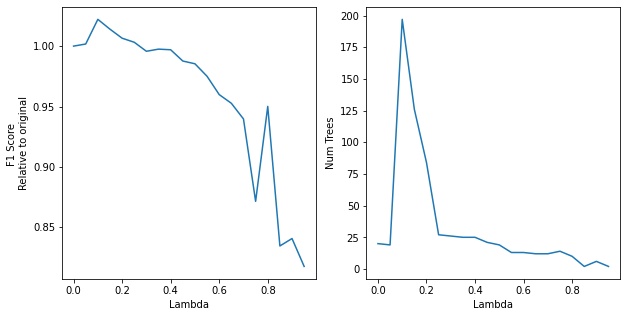

In [57]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(lams, [score/scores[0] for score in scores])
axs[0].set_xlabel('Lambda')
axs[0].set_ylabel(f'F1 Score \nRelative to original')

axs[1].plot(lams, trees)
axs[1].set_xlabel('Lambda')
axs[1].set_ylabel('Num Trees')

fig.savefig('../Data/Data/Figures/inprocessing_summary_i.svg')

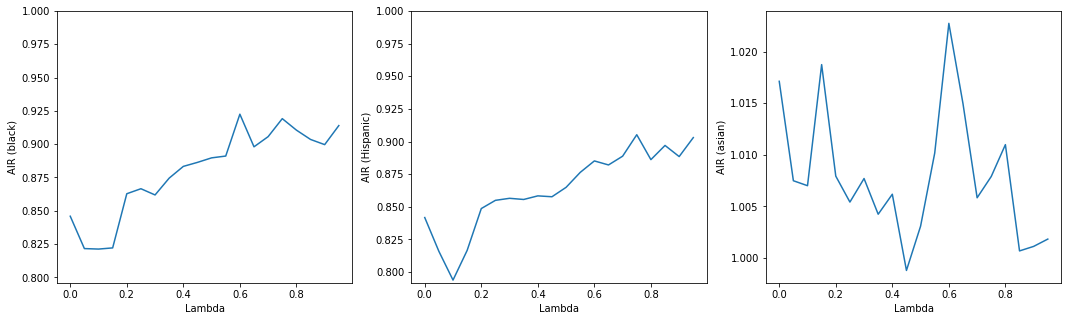

In [58]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
axs[0].plot(lams, air_black)
axs[0].set_xlabel('Lambda')
axs[0].set_ylabel('AIR (black)')
axs[0].set_ylim((air_black[0]-0.05, 1))

axs[1].plot(lams, air_hispanic)
axs[1].set_xlabel('Lambda')
axs[1].set_ylabel('AIR (Hispanic)')
axs[1].set_ylim((air_hispanic[0]-0.05, 1))


axs[2].plot(lams, air_asian)
axs[2].set_xlabel('Lambda')
axs[2].set_ylabel('AIR (asian)')

fig.savefig('../Data/Data/Figures/inprocessing_summary_ii.svg')

In [59]:
# Conduct a similar experiment with the magnitude of the reweighing scheme.

magnitudes = np.arange(0, 1.5, 0.05)
scores = []
trees = []

air_black_ii = []
air_hispanic_ii = [] 
air_asian_ii = [] 

dtest = xgb.DMatrix(test[features], label=test[target])

for mag in magnitudes:
    
    weight_change = 1 - train_weights
    new_train_weights = 1 - mag*weight_change

    dtrain = xgb.DMatrix(train[features], 
                     label=train[target],
                     weight=new_train_weights)


    model = xgb.train(params,         
                      dtrain,                   
                      num_boost_round=200,                     
                      evals=watchlist,
                      early_stopping_rounds=10,
                      verbose_eval=False)
    
    model_metrics = perf_metrics(y_true=valid[target], 
                                 y_score=model.predict(dvalid, iteration_range=(0, model.best_iteration)))
    best_cut = model_metrics.loc[model_metrics['f1'].idxmax(), 'cutoff']

    test[f'p_{target}_lam_test'] = model.predict(dtest, iteration_range=(0, model.best_iteration))

    air_table = fair_lending_disparity(test, y=target, yhat=f'p_{target}_lam_test', 
                                       demo_name='RACE', groups=race_levels, reference_group='white', 
                                       cutoff=best_cut)
    
    scores.append(model_metrics['f1'].max())
    trees.append(model.best_ntree_limit)
    
    air_black_ii.append(air_table.loc['black']['AIR'])
    air_hispanic_ii.append(air_table.loc['hispanic']['AIR'])
    air_asian_ii.append(air_table.loc['asian']['AIR'])
    

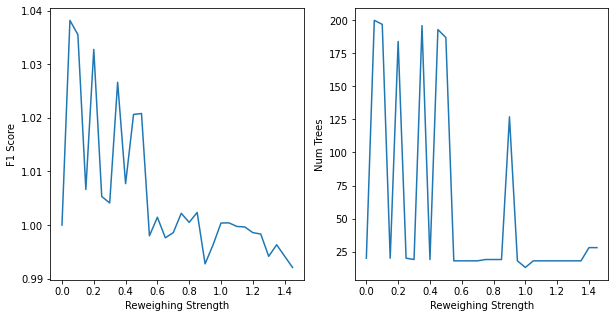

In [60]:
# This plot shows a relative drop in F1 score down to 94% of the original value. 
#  Meanwhile, black and Hispanic AIRs go from 0.72 to 0.9!

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(magnitudes, [score/scores[0] for score in scores])
axs[0].set_xlabel('Reweighing Strength')
axs[0].set_ylabel('F1 Score')

axs[1].plot(magnitudes, trees)
axs[1].set_xlabel('Reweighing Strength')
axs[1].set_ylabel('Num Trees')

fig.savefig('../Data/Data/Figures/preprocessing_summary_i.svg')

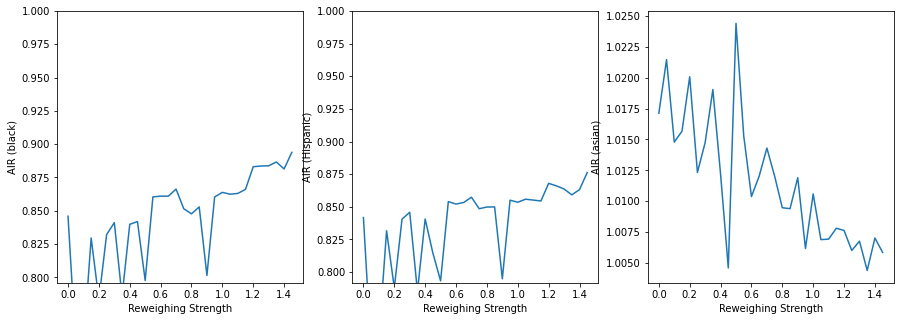

In [61]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].plot(magnitudes, air_black_ii)
axs[0].set_xlabel('Reweighing Strength')
axs[0].set_ylabel('AIR (black)')
axs[0].set_ylim((air_black_ii[0]-0.05, 1))

axs[1].plot(magnitudes, air_hispanic_ii)
axs[1].set_xlabel('Reweighing Strength')
axs[1].set_ylabel('AIR (Hispanic)')
axs[1].set_ylim((air_hispanic_ii[0]-0.05, 1))

axs[2].plot(magnitudes, air_asian_ii)
axs[2].set_xlabel('Reweighing Strength')
axs[2].set_ylabel('AIR (asian)')

fig.savefig('../Data/Data/Figures/preprocessing_summary_ii.svg')

### Post-Processing

In [62]:
def reject_option_classification(frame, y_hat, demo_name, protected_groups, reference_group, 
                                 cutoff, uncertainty_region_size, favorable_outcome=0):
    """
    In an uncertainty region around the decision cutoff value, flip protected group predictions to the 
    favorable decision and reference group predictions to the unfavorable decision.
    """
    new_predictions = frame[y_hat].values.copy()
    
    uncertain = np.where(np.abs(frame[y_hat] - cutoff) <= uncertainty_region_size, 1, 0)
    uncertain_protected = np.where(uncertain & frame[demo_name].isin(protected_groups), 1, 0)
    uncertain_reference = np.where(uncertain & (frame[demo_name] == reference_group), 1, 0)
    
    eps = 1e-3
    
    if favorable_outcome == 0:
        new_predictions = np.where(uncertain_protected, 
                                   cutoff - uncertainty_region_size - eps,
                                   new_predictions)
        new_predictions = np.where(uncertain_reference, 
                                   cutoff + uncertainty_region_size + eps,
                                   new_predictions)
    else:
        new_predictions = np.where(uncertain_protected, 
                                   cutoff + uncertainty_region_size + eps,
                                   new_predictions)
        new_predictions = np.where(uncertain_reference, 
                                   cutoff - uncertainty_region_size - eps,
                                   new_predictions)
        
    return new_predictions

In [63]:
train['p_DELINQ_NEXT_postprocessed'] = reject_option_classification(train, 'p_DELINQ_NEXT', 
                                                                    'RACE', ['black', 'hispanic'], 'white', 
                                                                    best_cut_original, uncertainty_region_size=0.05, 
                                                                    favorable_outcome=0)

valid['p_DELINQ_NEXT_postprocessed'] = reject_option_classification(valid, 'p_DELINQ_NEXT', 
                                                                    'RACE', ['black', 'hispanic'], 'white', 
                                                                    best_cut_original, uncertainty_region_size=0.05, 
                                                                    favorable_outcome=0)

test['p_DELINQ_NEXT_postprocessed'] = reject_option_classification(test, 'p_DELINQ_NEXT', 
                                                                    'RACE', ['black', 'hispanic'], 'white', 
                                                                    best_cut_original, uncertainty_region_size=0.05, 
                                                                    favorable_outcome=0)

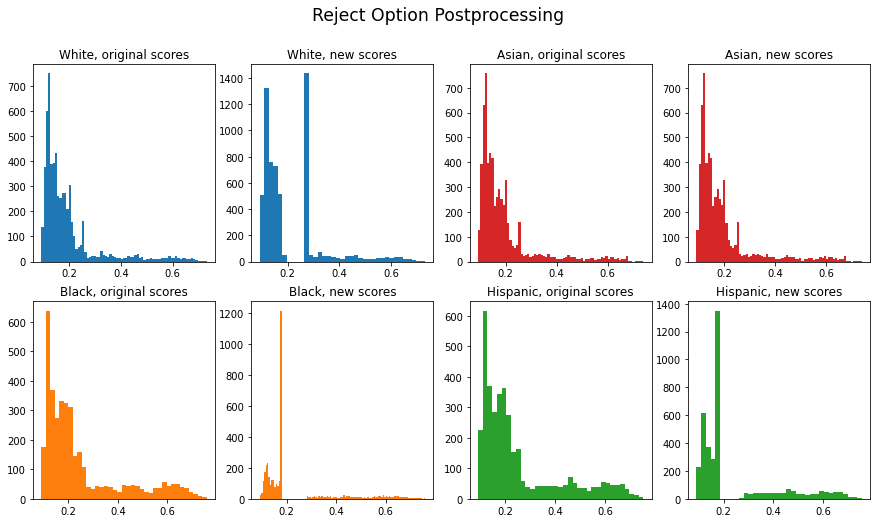

In [64]:
fig, axs = plt.subplots(2, 4, figsize=(15, 8))

fig.suptitle('Reject Option Postprocessing', size='xx-large')

axs[0, 0].hist(train.loc[train['RACE'] == 'white'][f'p_{target}'], bins='auto', color='C0')
axs[0, 0].set_title('White, original scores')
axs[0, 1].hist(train.loc[train['RACE'] == 'white'][f'p_{target}_postprocessed'], bins='auto', color='C0')
axs[0, 1].set_title('White, new scores')


axs[1, 0].hist(train.loc[train['RACE'] == 'black'][f'p_{target}'], bins='auto', color='C1')
axs[1, 0].set_title('Black, original scores')
axs[1, 1].hist(train.loc[train['RACE'] == 'black'][f'p_{target}_postprocessed'], bins='auto', color='C1')
axs[1, 1].set_title('Black, new scores')


axs[1, 2].hist(train.loc[train['RACE'] == 'hispanic'][f'p_{target}'], bins='auto', color='C2')
axs[1, 2].set_title('Hispanic, original scores')
axs[1, 3].hist(train.loc[train['RACE'] == 'hispanic'][f'p_{target}_postprocessed'], bins='auto', color='C2')
axs[1, 3].set_title('Hispanic, new scores')


axs[0, 2].hist(train.loc[train['RACE'] == 'asian'][f'p_{target}'], bins='auto', color='C3')
axs[0, 2].set_title('Asian, original scores')
axs[0, 3].hist(train.loc[train['RACE'] == 'asian'][f'p_{target}_postprocessed'], bins='auto', color='C3')
_ = axs[0, 3].set_title('Asian, new scores')

fig.savefig('../Data/Data/Figures/postprocessing_example.svg')

In [65]:
fair_lending_disparity(valid, y=target, yhat=f'p_{target}_postprocessed', 
                       demo_name='RACE', groups=race_levels, reference_group='white', 
                       cutoff=best_cut)

,Count,Favorable Outcomes,Favorable Rate,Mean Score,Std Score,AIR,AIR p-value,SMD,SMD p-value
hispanic,1016,758,0.746063,0.241583,0.147204,1.223387,1.128133e-12,0.162840,0.000059
black,1008,775,0.768849,0.232875,0.144961,1.260752,7.102823e-17,0.105284,0.006322
asian,1455,1203,0.826804,0.201322,0.130346,1.355786,1.690272e-39,-0.124981,0.999708
white,1566,955,0.609834,0.217613,0.132013,1.000000,1.000000e+00,0.000000,0.500000


In [66]:
metrics = perf_metrics(y_true=valid[target], 
                       y_score=valid[f'p_{target}_postprocessed'])

metrics.loc[metrics['cutoff'] == best_cut_original]


,cutoff,recall,precision,f1
23,0.23,0.538662,0.443808,0.486656


## <a name="model-selection"></a>3. Model Selection

### Feature Selection

Feature selection is a powerful technique for debiasing. We'll use the adversarial model we've already trained to inform which features we should drop.

In [67]:
adversarial_shap_values = pd.DataFrame(shap.TreeExplainer(adversary_model).shap_values(explanation_data[features]),
                                      columns=features)

In [68]:
# We'll examine the effect of dropping some of these features on model performance and adverse impact ratios.

features_to_drop = ['original model'] + list(adversarial_shap_values.abs().mean().sort_values(ascending=False).head(5).index)

In [69]:
num_cv_folds = 5

# Build the custom cross-validation iterable.
all_indices = np.arange(0, len(train))
all_indices = np.random.permutation(all_indices)
splits = np.array([int(np.floor(len(train)/num_cv_folds)) for _ in range(num_cv_folds-1)])
splits = np.append(splits, len(train) - splits.sum())

test_indices = np.split(all_indices, splits.cumsum())[:-1]
test_groups = [train.iloc[test_ind]['RACE'].values for test_ind in test_indices]

train_indices = [np.array([i for i in all_indices if i not in test_ind]) for test_ind in test_indices]

In [71]:

feature_selection_results = pd.DataFrame(index=features_to_drop, 
                                         columns=['AUC', 'Black AIR', 'Hispanic AIR'])

for dropped_feature in features_to_drop:
    
    new_features = list(set(features).difference(set([dropped_feature])))
    
    cv_auc = []
    cv_black_air = [] 
    cv_hispanic_air = [] 

    for fold_num, (train_ind, test_ind) in enumerate(zip(train_indices, test_indices)):

        new_monotone_constraints={k: v for k, v in dict(zip(features, monotone_constraints)).items() if k != dropped_feature}

        cv_model = xgb.XGBClassifier(n_estimators=150,
                                     max_depth=5,
                                     learning_rate=0.05,
                                     subsample=0.75,
                                     colsample_bytree=0.8,
                                     monotone_constraints=new_monotone_constraints,
                                     random_state=12345, 
                                     use_label_encoder=False,
                                     base_score=params['base_score'],
                                     eval_metric='logloss')

        train_slice = train.reset_index(drop=True).iloc[train_ind].copy()
        test_slice = train.reset_index(drop=True).iloc[test_ind].copy()
        
        cv_model = cv_model.fit(train_slice[new_features],
                                train_slice[target])
        y_pred = cv_model.predict_proba(test_slice[new_features])[:, 1]


        model_metrics = perf_metrics(y_true=train[target].values[test_ind], y_score=y_pred)
        best_cut = model_metrics.loc[model_metrics['f1'].idxmax(), 'cutoff']

        cv_auc.append(sklearn.metrics.roc_auc_score(y_true=train[target].values[test_ind], 
                                                    y_score=y_pred))

        test_slice['pred'] = y_pred
        disparity_table = fair_lending_disparity(test_slice, y=target, yhat=f'pred', 
                           demo_name='RACE', groups=race_levels, reference_group='white', 
                           cutoff=best_cut)

        cv_black_air.append(disparity_table.loc['black']['AIR'])
        cv_hispanic_air.append(disparity_table.loc['hispanic']['AIR'])
        
    feature_selection_results.loc[dropped_feature] = [np.mean(cv_auc), 
                                                      np.mean(cv_black_air), 
                                                      np.mean(cv_hispanic_air)]

In [72]:
feature_selection_results

,AUC,Black AIR,Hispanic AIR
original model,0.792301,0.758368,0.748172
PAY_AMT5,0.789607,0.768391,0.754509
PAY_AMT6,0.79123,0.758182,0.750611
PAY_AMT1,0.791337,0.761148,0.748471
BILL_AMT6,0.79056,0.764184,0.740473
LIMIT_BAL,0.784347,0.768594,0.766542


In [73]:
new_features = list(set(features).difference(set(['PAY_AMT5'])))
new_monotone_constraints={k: v for k, v in dict(zip(features, monotone_constraints)).items() if k in new_features}

### Hyperparameter Tuning

In [74]:
parameter_distributions = {
    'n_estimators': np.arange(10, 221, 30),
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': stats.uniform(0.01, 0.1),
    'subsample': stats.uniform(0.7, 0.3),
    'colsample_bytree': stats.uniform(0.5, 0.5),
    'reg_lambda': stats.uniform(0.1, 50),
    'monotone_constraints': [new_monotone_constraints],
    'base_score': [params['base_score']]
    }

In [75]:
fold_number = -1

def black_air(y_true, y_pred):
    
    global fold_number
    fold_number = (fold_number + 1) % num_cv_folds

    model_metrics = perf_metrics(y_true, y_score=y_pred)
    best_cut = model_metrics.loc[model_metrics['f1'].idxmax(), 'cutoff']

    data = pd.DataFrame({'RACE': test_groups[fold_number],
                        'y_true': y_true,
                        'y_pred': y_pred},
                        index=np.arange(len(y_pred)))

    disparity_table = fair_lending_disparity(data, y='y_true', yhat='y_pred', 
                       demo_name='RACE', groups=race_levels, reference_group='white', 
                       cutoff=best_cut)

    return disparity_table.loc['black']['AIR']


def hispanic_air(y_true, y_pred):
    
    global fold_number
    
    model_metrics = perf_metrics(y_true, y_score=y_pred)
    best_cut = model_metrics.loc[model_metrics['f1'].idxmax(), 'cutoff']
    
    data = pd.DataFrame({'RACE': test_groups[fold_number],
                        'y_true': y_true,
                        'y_pred': y_pred},
                        index=np.arange(len(y_pred)))

    disparity_table = fair_lending_disparity(data, y='y_true', yhat='y_pred', 
                       demo_name='RACE', groups=race_levels, reference_group='white', 
                       cutoff=best_cut)

    return disparity_table.loc['hispanic']['AIR']

scoring = {
        'AUC': 'roc_auc',
        'Black AIR': sklearn.metrics.make_scorer(black_air, needs_proba=True),
        'Hispanic AIR': sklearn.metrics.make_scorer(hispanic_air, needs_proba=True)
    }

In [76]:
grid_search = sklearn.model_selection.RandomizedSearchCV(xgb.XGBClassifier(random_state=12345, 
                                                                           use_label_encoder=False,
                                                                           eval_metric='logloss'), 
                                                         parameter_distributions, 
                                                         n_iter=50, 
                                                         scoring=scoring, 
                                                         cv=zip(train_indices, test_indices),
                                                         refit=False,
                                                         error_score='raise').fit(train[new_features], train[target].values)
results = pd.DataFrame(grid_search.cv_results_)

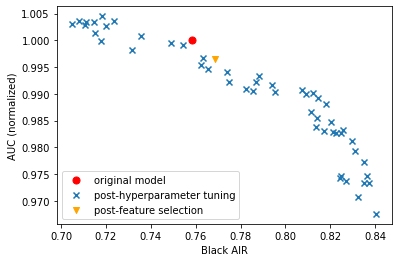

In [77]:
original_auc = feature_selection_results.loc['original model']['AUC']
original_black_air = feature_selection_results.loc['original model']['Black AIR']

new_auc = feature_selection_results.loc['PAY_AMT5']['AUC']
new_black_air = feature_selection_results.loc['PAY_AMT5']['Black AIR']

fig, ax = plt.subplots()
ax.scatter(original_black_air, 1.0, s=50, color='red', label='original model')
ax.scatter(results['mean_test_Black AIR'], results['mean_test_AUC']/original_auc, label='post-hyperparameter tuning', marker='x')
ax.scatter(new_black_air, new_auc/original_auc, color='orange', label='post-feature selection', marker='v')
ax.legend()
ax.set_xlabel('Black AIR')
ax.set_ylabel('AUC (normalized)')

fig.savefig('../Data/Data/Figures/model_tuning_scatter.svg')

In [78]:

results[['mean_test_Black AIR', 'mean_test_Hispanic AIR', 'mean_test_AUC']].sort_values(['mean_test_Black AIR', 'mean_test_AUC'], ascending=False)

highest_air_idx = results.loc[results['mean_test_Black AIR'] == results['mean_test_Black AIR'].max()].index[0]

# We can also choose the fairest model that demonstrates no more than a 1% decrease in AUC from the original model.
business_viable_models = results.loc[results['mean_test_AUC'] >= 0.99*original_auc]
alternative_model_idx = business_viable_models.loc[business_viable_models['mean_test_Black AIR'] == business_viable_models['mean_test_Black AIR'].max()].index[0]


In [79]:
new_hyperparameter_idx = [highest_air_idx, alternative_model_idx]

tuned_params = ['_'.join(col.split('_')[1:]) for col in results.columns if col.startswith('param_')]
new_hyperparameters = [dict(zip(tuned_params, [row[f'param_{param}'] for param in tuned_params])) for _, row in results.loc[new_hyperparameter_idx].iterrows()]

### Conclusion

In [80]:
def model_summary(y_true, y_pred, group_info, reference_group, metric_dict, cutoff,
                  confusion_metrics_to_show=['False Positive Rate']):

    groups = np.unique(group_info)
    protected_groups = [group for group in groups if group != reference_group]
    
    model_metrics = perf_metrics(y_true, y_score=y_pred)
    # best_cut = model_metrics.loc[model_metrics['f1'].idxmax(), 'cutoff']
    # f1 = model_metrics['f1'].max()

    f1 = model_metrics.loc[model_metrics['cutoff'] == cutoff, 'f1'].values[0]

    auc = sklearn.metrics.roc_auc_score(y_true, y_score=y_pred)
    
    data = pd.DataFrame({'demo': group_info,
                        'y_true': y_true,
                        'y_pred': y_pred},
                        index=np.arange(len(y_pred)))

    disparity_table = fair_lending_disparity(data, y='y_true', yhat='y_pred', 
                       demo_name='demo', groups=groups, reference_group=reference_group, 
                       cutoff=cutoff)

    airs = dict(zip([f'{group} AIR' for group in protected_groups], 
                    [disparity_table.loc[group]['AIR'] for group in protected_groups]))
    
    confusion_mats = {level: get_confusion_matrix(data, 'y_true', 'y_pred', by='demo', 
                                                  level=level, cutoff=cutoff) for level in groups} 
    confusion_metrics = confusion_matrix_metrics(confusion_mats, metric_dict)
    confusion_disparity_frame = confusion_metrics/confusion_metrics.loc[reference_group, :]

    confusion_metric_disparities = dict()
    for metric in confusion_metrics_to_show:
        confusion_metric_disparities.update(dict(zip([f"{group} {metric} Disparity" for group in protected_groups],
                                               [confusion_disparity_frame.loc[group][metric] for group in protected_groups])))
    
    output = {'AUC': auc, 'F1': f1}
    output.update(airs)
    output.update(confusion_metric_disparities)
    
    return pd.Series(output)

In [81]:
feature_selection_model = xgb.XGBClassifier(n_estimators=150,
                                     max_depth=5,
                                     learning_rate=0.05,
                                     subsample=0.75,
                                     colsample_bytree=0.8,
                                     monotone_constraints=new_monotone_constraints,
                                     random_state=12345, 
                                     use_label_encoder=False,
                                     base_score=params['base_score'],
                                     eval_metric='logloss').fit(train[new_features], train[target])


model_metrics = perf_metrics(y_true=valid[target], 
                             y_score=feature_selection_model.predict_proba(valid[new_features])[:, 1])
best_cut_feature_selection = model_metrics.loc[model_metrics['f1'].idxmax(), 'cutoff']

hyp_tuning_model_1 = xgb.XGBClassifier(random_state=12345, 
                                     use_label_encoder=False,
                                     eval_metric='logloss', **new_hyperparameters[0]).fit(train[new_features], train[target])

model_metrics = perf_metrics(y_true=valid[target], 
                             y_score=hyp_tuning_model_1.predict_proba(valid[new_features])[:, 1])
best_cut_hyp_1 = model_metrics.loc[model_metrics['f1'].idxmax(), 'cutoff']

hyp_tuning_model_2 = xgb.XGBClassifier(random_state=12345, 
                                     use_label_encoder=False,
                                     eval_metric='logloss', **new_hyperparameters[1]).fit(train[new_features], train[target])


model_metrics = perf_metrics(y_true=valid[target], 
                             y_score=hyp_tuning_model_2.predict_proba(valid[new_features])[:, 1])
best_cut_hyp_2 = model_metrics.loc[model_metrics['f1'].idxmax(), 'cutoff']


In [82]:
model_predictions = {'Original Model': (test[f"p_{target}"].values, best_cut_original),
                    'Pre-processing (reweighting)': (test[f'p_{target}_reweighted'].values, reweighted_best_cut), 
                    'In-processing (regularized, lam = 0.2)': (test[f'p_{target}_regularized'].values, best_cut_regularized), 
                    'Post-processing (reject option, window size = 0.1)': (test[f'p_{target}_postprocessed'].values, best_cut_original),
                    'Feature selection': (feature_selection_model.predict_proba(test[new_features])[:, 1], best_cut_feature_selection), 
                    'Hyperparameter tuning #1': (hyp_tuning_model_1.predict_proba(test[new_features])[:, 1], best_cut_hyp_1), 
                    'Hyperparameter tuning #2': (hyp_tuning_model_2.predict_proba(test[new_features])[:, 1], best_cut_hyp_2)}

In [83]:
model_summaries = {name: model_summary(test[target].values, pred, test['RACE'].values, 'white', metric_dict, cutoff) for name, (pred, cutoff) in model_predictions.items()}

In [84]:
pd.DataFrame(model_summaries)

,Original Model,Pre-processing (reweighting),"In-processing (regularized, lam = 0.2)","Post-processing (reject option, window size = 0.1)",Feature selection,Hyperparameter tuning #1,Hyperparameter tuning #2
AUC,0.780119,0.769936,0.776305,0.763097,0.793435,0.767158,0.787242
F1,0.540541,0.543897,0.541630,0.482252,0.550749,0.514946,0.541962
asian AIR,1.016807,1.011767,1.008237,1.263674,1.013490,0.998792,1.020278
black AIR,0.826084,0.853233,0.866043,1.182294,0.768152,0.837812,0.810223
hispanic AIR,0.839587,0.857953,0.848276,1.141298,0.755395,0.835943,0.804630
asian False Positive Rate Disparity,0.889434,0.906981,0.935706,0.444717,0.885816,0.989811,0.879259
black False Positive Rate Disparity,1.248249,1.061766,1.065253,0.309483,1.607871,1.158960,1.295322
hispanic False Positive Rate Disparity,1.036509,0.949838,1.034060,0.359605,1.547029,1.072084,1.232414
